In [4]:
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import math
from tensorflow import keras
from keras.layers import Dense, Input, Dropout
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
from joblib import dump, load
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import re
from keras.layers import LSTM
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
import statsmodels.api as sm
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout
import pywt

# Modelo mejorado para pronóstico de serie de tiempo

Una vez hemos hecho el despliegue de los distintos modelos de Suavización, ARIMA y Redes Neuronales, es momento de presentar un modelo mejorado de pronóstico, con el que podamos conseguir el menor MAE posible. Para ello citamos el artículo académico de Burak Gülmez, Stock price prediction with optimized deep LSTM network with artificial rabbits optimization algorithm [[Fuente]](https://www.sciencedirect.com/science/article/pii/S0957417423008485). En este artículo el autor hace uso de un modelo de selección de mejores parámetros para entrenar su modelo LSTM.

En nuestro caso y dado el análisis anterior, no vamos a buscar encontrar mejores parámetros para el modelo LSTM, sino para el modelo RNN, además los parámetros que buscamos mejorar solo será el número de neuronas y la tasa de drop_out, dado que las épocas quedarán fijas en 25.

## 1. Cargue de datos y funciones complementarias

Vamos a cargar los datos de nuestra serie de tiempo, así como funciones complementarias que hemos utilizado en otros capítulos.

In [14]:
df=pd.read_excel("loadsts.xlsx")
df.index = df['Posted_date']
df.index.freq = 'D'
ts = df['Loads']

df['loads_escaler'] = df['Loads']
scaler = MinMaxScaler(feature_range=(0, 1))
ts_esc = scaler.fit_transform(np.array(df['loads_escaler']).reshape(-1, 1))

In [9]:
def makeXy(ts, nbtimesteps):
    X = []
    y = []
    for i in range(nbtimesteps, ts.shape[0]):
        X.append(list(ts[i-nbtimesteps:i-1])) #Regressors
        y.append(ts[i]) #Target
    X, y = np.array(X), np.array(y)
    return X, y

In [11]:
def split(serie, trainportion):
    perct = math.ceil(len(ts) * trainportion)
    perc2 = math.ceil(len(ts)*((1 - trainportion)/2))
    train = serie[0:perct]
    validation = serie[perct:perct+perc2]
    test = serie[perct+perc2:]
    return train, validation, test

In [ ]:
def errors(y_pred, y_real):
    
    mae = mean_absolute_error(y_real, y_pred)
    mape = 100*(sum(abs(((y_real - y_pred)/y_real)))/len(y_real))
    mse = mean_squared_error(y_real , y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_real, y_pred)
    
    return mae, mape, mse, rmse, r2

Además, agregamos al código, las funciones de creación de redes recurrentes y de selección del mejor modelo, con el fin de complementar la selección de modelos por parte del optimizador.

In [30]:
def create_RNN(neurons, shape, dropout_rate): #Creación RNN
    model_RNN = Sequential()
    model_RNN.add(SimpleRNN(neurons, input_shape=(shape,1), activation='relu'))
    model_RNN.add(Dropout(dropout_rate))
    model_RNN.add(Dense(1, activation='linear'))
    model_RNN.compile(loss='mean_squared_error', optimizer='adam')

    return model_RNN

In [ ]:
def select_model(model, ep, X_train, y_train, X_val, y_val):

    save_weights_at = os.path.join('keras_models', f'{model.name}_{{epoch:02d}}-{{val_loss:.4f}}.keras')
    save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch');
    
    history_filename = os.path.join('historynn', f'history_{model.name}.joblib')
    history_airp = None

    if os.path.exists(history_filename):
        history_filename = history_filename
        print("El archivo '{history_filename}' ya existe. Se ha cargado el historial del entrenamiento.")
        
    else:
        history_airp = model.fit(x=X_train, y=y_train, batch_size=16, epochs=ep,
                 verbose=2, callbacks=[save_best], validation_data=(X_val, y_val),
                 shuffle=True);
        
        dump(history_airp.history, history_filename)
        print("El entrenamiento se ha completado y el historial ha sido guardado en '{history_filename}'")

    model_dir = 'keras_models'
    files = os.listdir(model_dir)
    pattern = rf"{re.escape(model.name)}_(\d+)-([\d\.]+)\.keras"
    
    best_val_loss = float('inf')
    best_model_file = None
    best_model = None
    
    for file in files:
        match = re.match(pattern, file)
        if match:
            epoch = int(match.group(1))
            val_loss = float(match.group(2))
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_file = file

    if best_model_file:
        best_model_path = os.path.join(model_dir, best_model_file)
        print(f"Cargando el mejor modelo: {best_model_file} con val_loss: {best_val_loss}")
        best_model = load_model(best_model_path)
    else:
        print("No se encontraron archivos de modelos que coincidan con el patrón.")

    return best_model

In [ ]:
#forecast
def forecast_nw(best_model, X_val):
    preds = best_model.predict(X_val)
    preds = scaler.inverse_transform(preds)
    preds = np.squeeze(preds)
    return preds

De nuevo vamos a hacer una división de 80% para el conjunto de training.

In [15]:
train, val, test = split(ts, 0.8)
train_esc, val_esc, test_esc = split(ts_esc, 0.8)

## 2. Artificial Rabbits Optimization Algorithm

Esta función se encarga de, para cada populación, iterar n veces tomando distintos valores de drop_out y neuronas, y entrenar un modelo RNN para esos parámetros. Cada vez que identifica que la métrica de interés mejoró, en este caso MAE, guarda los valores. Observe que en este caso las neuronas tienen un valor de 50 a 100 y el drop_out de 0.4 a 0.7, esto dados los valores encontrados en la sección preliminar, donde se conoció los valores para los cuales el test obtenía un valor mayor.

Es importante considerar que, en todos los casos, los modelos parametrizados que han superado la validación en primer lugar, no necesariamente presentan buen desempeño durante el testing. De hecho en ningún caso la combinación de parámetros adecuada para la validación se mantuvo en primera posición para el testing.

In [68]:
class ArtificialRabbitsOptimizer:
    def __init__(self, population_size, n_iterations):
        self.population_size = population_size
        self.n_iterations = n_iterations

    def optimize(self, X_train, y_train, X_val, y_val):
        best_parameters = None
        best_score = float('inf')
        i=0
        for _ in range(self.n_iterations):
            for _ in range(self.population_size):
                i = i+1
                print("iteracion", i+1)
                neurons = np.random.randint(100, 1000)  # Número de neuronas
                dropout_rate = np.random.uniform(0.4, 0.7)  # Tasa de dropout
                
                score = self.evaluate_model(neurons, dropout_rate, X_train, y_train, X_val, y_val)
                
                if score < best_score:
                    best_score = score
                    best_parameters = (neurons, dropout_rate)

        return best_parameters

    @staticmethod
    def evaluate_model(neurons, dropout_rate, X_train, y_train, X_val, y_val):
        model = create_RNN(neurons, 4, dropout_rate)
        best_model = select_model(model, 10, X_train, y_train, X_val, y_val)
        y_pred = best_model.predict(X_val)
        score = mean_absolute_error(y_val, y_pred)
        
        return score

Como mencionamos anteriormente, se combinó con la función _'ArtificialRabbitsOptimizer'_, el método de captación de mejor modelo que habíamos utilizado anteriormente. Y además, se dejó fijo un input layer de 4 observaciones, dado que fue la opción que mejor desempeñó mostró durante el testing.

## 3. Generación de los modelos

En el siguiente comando, haremos uso de 10 iteraciones y un tamaño de población de 7 con el fin de recorrer el espacio de búsqueda. Además agregamos los conjuntos de entrenamiento y validación.

In [44]:
s = 4
X_train, y_train = makeXy(train_esc, s+1)
X_val, y_val = makeXy(val_esc, s+1)
X_test, y_test = makeXy(test_esc, s+1)
    
X_valr, y_valr = makeXy(val, s+1)
X_testr, y_testr = makeXy(test, s+1)

In [69]:
if __name__ == "__main__":
    
    optimizer = ArtificialRabbitsOptimizer(population_size=10, n_iterations=10)
    best_neurons, best_dropout = optimizer.optimize(X_train, y_train, X_val, y_val)
    
    print(f"Mejores parámetros: Neurones: {best_neurons}, Dropout: {best_dropout}")

iteracion 2
Epoch 1/10
65/65 - 2s - 26ms/step - loss: 0.0359 - val_loss: 0.0335
Epoch 2/10
65/65 - 0s - 7ms/step - loss: 0.0193 - val_loss: 0.0375
Epoch 3/10
65/65 - 0s - 8ms/step - loss: 0.0160 - val_loss: 0.0331
Epoch 4/10
65/65 - 0s - 7ms/step - loss: 0.0148 - val_loss: 0.0302
Epoch 5/10
65/65 - 0s - 6ms/step - loss: 0.0144 - val_loss: 0.0312
Epoch 6/10
65/65 - 0s - 7ms/step - loss: 0.0144 - val_loss: 0.0302
Epoch 7/10
65/65 - 0s - 7ms/step - loss: 0.0133 - val_loss: 0.0297
Epoch 8/10
65/65 - 0s - 6ms/step - loss: 0.0128 - val_loss: 0.0321
Epoch 9/10
65/65 - 0s - 6ms/step - loss: 0.0130 - val_loss: 0.0306
Epoch 10/10
65/65 - 0s - 7ms/step - loss: 0.0134 - val_loss: 0.0337
El entrenamiento se ha completado y el historial ha sido guardado en '{history_filename}'
Cargando el mejor modelo: sequential_502_07-0.0297.keras con val_loss: 0.0297
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
iteracion 3
Epoch 1/10
65/65 - 2s - 35ms/step - loss: 0.0288 - val_loss: 0.0353
Epoch 2/10
65/65 - 1s - 14ms/s

Se realizaron 4 corridas del algoritmo para las siguientes combinaciones: 

**1. Epochs = 10, population_size = 10, iterations = 20, neurons = (0, 100), drop_out = (0.1, 0.5)**
    Para la primera combinación de parámetros el resultado obtenido fueron 87 neuronas y una tasa de drop_out de 0.19. En este caso, el MAE conseguido fue 8.2 unidades.
   
**2. Epochs = 25, population_size = 10, iterations = 20, neurons = (50, 100), drop_out = (0.1, 0.5)**
    Con la segunda, el valor fue 51 neuronas, con una tasa de dropout de 0.3. Y un MAE de 8.4
   
**3. Epochs = 25, population_size = 7, iterations = 10, neurons = (50, 100), drop_out = (0.4, 0.7)**
    La tercera resultó en 62 neuronas con 0.4 de tasa de drop_out. El MAE en este caso fue de 7.83.
   
**4. Epochs = 10, population_size = 10, iterations = 10, neurons = (100, 1000), drop_out = (0.4, 0.7)**. En esta última combinación, se obtuvo como resultado el mejor valor de MAE con 7.37.

## 4. Pronóstico con mejor modelo generado

A continuación se despliegan algunas pruebas de modelo a partir de la combinación de los output generados con el algoritmo. Algunas combinaciones se hicieron considerando el drop_out de 0.6 que se observó en el capítulo anterior, y el MAE mejoró considerablemente, sin embargo, no es apropiado realizar estas modificaciones dado que no conocemos el verdadero valor del test.

In [74]:
model = create_RNN(87, 4, 0.19)
best_model = select_model(model, 25, X_train, y_train, X_val, y_val)

val_pred = forecast_nw(best_model, X_val)
test_pred = forecast_nw(best_model, X_test)
errors(test_pred, y_testr)
#errors(val_pred, y_valr)

Epoch 1/25
65/65 - 2s - 26ms/step - loss: 0.0389 - val_loss: 0.0403
Epoch 2/25
65/65 - 0s - 5ms/step - loss: 0.0205 - val_loss: 0.0327
Epoch 3/25
65/65 - 0s - 5ms/step - loss: 0.0173 - val_loss: 0.0303
Epoch 4/25
65/65 - 0s - 5ms/step - loss: 0.0153 - val_loss: 0.0334
Epoch 5/25
65/65 - 0s - 6ms/step - loss: 0.0149 - val_loss: 0.0309
Epoch 6/25
65/65 - 0s - 6ms/step - loss: 0.0137 - val_loss: 0.0303
Epoch 7/25
65/65 - 0s - 4ms/step - loss: 0.0135 - val_loss: 0.0295
Epoch 8/25
65/65 - 0s - 5ms/step - loss: 0.0127 - val_loss: 0.0308
Epoch 9/25
65/65 - 0s - 4ms/step - loss: 0.0134 - val_loss: 0.0296
Epoch 10/25
65/65 - 0s - 4ms/step - loss: 0.0118 - val_loss: 0.0296
Epoch 11/25
65/65 - 0s - 6ms/step - loss: 0.0116 - val_loss: 0.0282
Epoch 12/25
65/65 - 0s - 5ms/step - loss: 0.0117 - val_loss: 0.0291
Epoch 13/25
65/65 - 0s - 4ms/step - loss: 0.0117 - val_loss: 0.0316
Epoch 14/25
65/65 - 0s - 6ms/step - loss: 0.0121 - val_loss: 0.0280
Epoch 15/25
65/65 - 0s - 6ms/step - loss: 0.0113 - val_l

(7.734648735875764,
 inf,
 121.32080316097121,
 11.014572309489425,
 0.6612727642059326)

In [73]:
model = create_RNN(62, 4, 0.6)
best_model = select_model(model, 25, X_train, y_train, X_val, y_val)

val_pred = forecast_nw(best_model, X_val)
test_pred = forecast_nw(best_model, X_test)
errors(test_pred, y_testr)
#errors(val_pred, y_valr)

Epoch 1/25
65/65 - 2s - 25ms/step - loss: 0.0692 - val_loss: 0.0659
Epoch 2/25
65/65 - 0s - 5ms/step - loss: 0.0369 - val_loss: 0.0552
Epoch 3/25
65/65 - 0s - 6ms/step - loss: 0.0303 - val_loss: 0.0410
Epoch 4/25
65/65 - 0s - 4ms/step - loss: 0.0255 - val_loss: 0.0380
Epoch 5/25
65/65 - 0s - 6ms/step - loss: 0.0237 - val_loss: 0.0371
Epoch 6/25
65/65 - 0s - 6ms/step - loss: 0.0214 - val_loss: 0.0331
Epoch 7/25
65/65 - 0s - 5ms/step - loss: 0.0211 - val_loss: 0.0324
Epoch 8/25
65/65 - 0s - 5ms/step - loss: 0.0196 - val_loss: 0.0353
Epoch 9/25
65/65 - 0s - 5ms/step - loss: 0.0189 - val_loss: 0.0326
Epoch 10/25
65/65 - 0s - 5ms/step - loss: 0.0185 - val_loss: 0.0339
Epoch 11/25
65/65 - 0s - 6ms/step - loss: 0.0189 - val_loss: 0.0303
Epoch 12/25
65/65 - 0s - 5ms/step - loss: 0.0175 - val_loss: 0.0308
Epoch 13/25
65/65 - 0s - 6ms/step - loss: 0.0166 - val_loss: 0.0302
Epoch 14/25
65/65 - 0s - 6ms/step - loss: 0.0162 - val_loss: 0.0299
Epoch 15/25
65/65 - 0s - 5ms/step - loss: 0.0162 - val_l

(7.644078879821591,
 inf,
 122.84081866181019,
 11.08335773408989,
 0.6570289134979248)

In [72]:
model = create_RNN(251, 4, 0.6)
best_model = select_model(model, 25, X_train, y_train, X_val, y_val)

val_pred = forecast_nw(best_model, X_val)
test_pred = forecast_nw(best_model, X_test)
errors(test_pred, y_testr)
#errors(val_pred, y_valr)

Epoch 1/25
65/65 - 2s - 26ms/step - loss: 0.0343 - val_loss: 0.0351
Epoch 2/25
65/65 - 0s - 6ms/step - loss: 0.0198 - val_loss: 0.0342
Epoch 3/25
65/65 - 0s - 6ms/step - loss: 0.0175 - val_loss: 0.0309
Epoch 4/25
65/65 - 0s - 4ms/step - loss: 0.0155 - val_loss: 0.0330
Epoch 5/25
65/65 - 0s - 6ms/step - loss: 0.0156 - val_loss: 0.0330
Epoch 6/25
65/65 - 0s - 5ms/step - loss: 0.0154 - val_loss: 0.0334
Epoch 7/25
65/65 - 0s - 6ms/step - loss: 0.0135 - val_loss: 0.0290
Epoch 8/25
65/65 - 0s - 6ms/step - loss: 0.0135 - val_loss: 0.0285
Epoch 9/25
65/65 - 0s - 5ms/step - loss: 0.0130 - val_loss: 0.0290
Epoch 10/25
65/65 - 0s - 6ms/step - loss: 0.0128 - val_loss: 0.0298
Epoch 11/25
65/65 - 0s - 7ms/step - loss: 0.0117 - val_loss: 0.0304
Epoch 12/25
65/65 - 0s - 7ms/step - loss: 0.0130 - val_loss: 0.0311
Epoch 13/25
65/65 - 0s - 7ms/step - loss: 0.0131 - val_loss: 0.0288
Epoch 14/25
65/65 - 0s - 6ms/step - loss: 0.0126 - val_loss: 0.0306
Epoch 15/25
65/65 - 0s - 7ms/step - loss: 0.0123 - val_l

(8.544620022541139,
 inf,
 149.27465245476975,
 12.217800639017227,
 0.5832257866859436)

Como mencionamos anteriormente cuando se amplió el espacio de búsqueda del algoritmo, de 100 a 1000 neuronas se obtuvo el mejor valor de MAE. Que se calcula en el comando a continuación:

In [76]:
model = create_RNN(251, 4, 0.43796127455307554)
best_model = select_model(model, 25, X_train, y_train, X_val, y_val)

val_pred = forecast_nw(best_model, X_val)
test_pred = forecast_nw(best_model, X_test)
errors(test_pred, y_testr)
#errors(val_pred, y_valr)

Epoch 1/25
65/65 - 2s - 26ms/step - loss: 0.0334 - val_loss: 0.0362
Epoch 2/25
65/65 - 1s - 8ms/step - loss: 0.0186 - val_loss: 0.0342
Epoch 3/25
65/65 - 0s - 7ms/step - loss: 0.0174 - val_loss: 0.0312
Epoch 4/25
65/65 - 0s - 7ms/step - loss: 0.0139 - val_loss: 0.0321
Epoch 5/25
65/65 - 0s - 7ms/step - loss: 0.0140 - val_loss: 0.0295
Epoch 6/25
65/65 - 1s - 8ms/step - loss: 0.0127 - val_loss: 0.0322
Epoch 7/25
65/65 - 0s - 7ms/step - loss: 0.0123 - val_loss: 0.0309
Epoch 8/25
65/65 - 0s - 7ms/step - loss: 0.0117 - val_loss: 0.0295
Epoch 9/25
65/65 - 0s - 6ms/step - loss: 0.0124 - val_loss: 0.0302
Epoch 10/25
65/65 - 0s - 6ms/step - loss: 0.0118 - val_loss: 0.0321
Epoch 11/25
65/65 - 0s - 6ms/step - loss: 0.0118 - val_loss: 0.0306
Epoch 12/25
65/65 - 0s - 5ms/step - loss: 0.0114 - val_loss: 0.0336
Epoch 13/25
65/65 - 0s - 4ms/step - loss: 0.0125 - val_loss: 0.0306
Epoch 14/25
65/65 - 0s - 5ms/step - loss: 0.0122 - val_loss: 0.0353
Epoch 15/25
65/65 - 0s - 4ms/step - loss: 0.0125 - val_l

(7.372285649059265,
 inf,
 122.42857780898511,
 11.06474481445393,
 0.6581798791885376)

Este valor de MAE es menor al obtenido en el capítulo anterior que estaba en 7.46 unidades, por lo que sí se evidencia que este algoritmo permite mejorar la RNN dada la optimización en la búsqueda de los mejores parámetros.

No solamente nos permitió apuntarle a un mejor valor de parámetros, sino que el tiempo de corrida entre este camino y el anteriormente planteado en el ciclo, fue menor, no fue necesario tampoco utilizar un mayor número de épocas, con 10 bastó para encontrar una buena combinación, a diferencia de la anterior que estuvo en 25 y que aumenta considerablemente el tiempo computacional requerido.

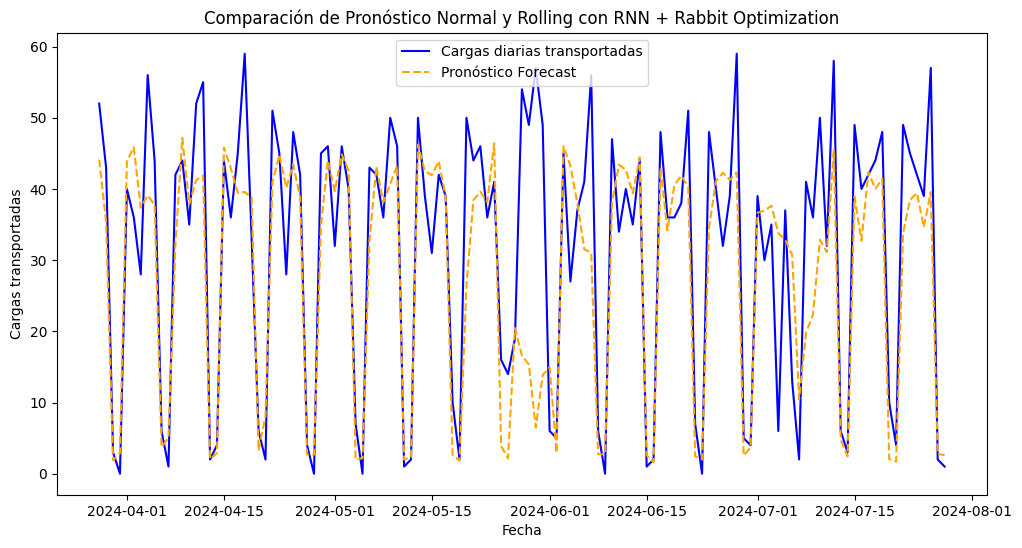

In [78]:
plt.figure(figsize=(12, 6))
plt.plot(test[5:].index, y_testr, label='Cargas diarias transportadas', color='blue')
plt.plot(test[5:].index, test_pred, label='Pronóstico Forecast', color='orange', linestyle='--')
plt.title('Comparación de Pronóstico Normal y Rolling con RNN + Rabbit Optimization')
plt.xlabel('Fecha')
plt.ylabel('Cargas transportadas')
plt.legend()
plt.show()

## 5. Conclusiones y trabajos futuros

Los resultados con el algoritmo de Rabbit Optimization mejoraron considerablemente el MAE obtenido de la RNN del capítulo anterior, además, con un menor tiempo computacional. En este caso vale resaltar que conocer los resultados obtenidos en el ciclo anterior apoyaron la limitación de las fronteras de análisis, entonces está bien acompañar el lanzamiento de la búsqueda del Rabbit Optimization con un análisis preliminar de algunos valores y la comparación de estos con respecto al MAE.

Además, es importante agregar a este estudio un análisis de optimización de parámetros y capacidad para seguir mejorando, dado que realmente no conocemos en este punto si hemos alcanzado el óptimo.

Además, en el análisis de 'val_loss' observado para las distintas corridas del algoritmo no se observó en ningún momento valores menores a 0.02, es posible que otras técnicas puedan mejorar este valor. En este análisis, por ejemplo, no se incluyó más de una capa, ni se modificó la función de activación, tampoco se trabajó en modificar el batch_size de la función, es decir, existen distintos parámetros que se pueden seguir revisando con el fin de encontrar una combinación que permita seguir disminuyendo el valor del MAE.

En definitiva la complejidad en el pronóstico de series de este tipo que presentaron desde el inicio alta variabilidad y cero distribución normal, era de esperarse que fuera difícil para modelos ARIMA y de Suavización captar esos patrones, y el uso de redes neuronales mejoró notablemente la capacidad del pronóstico y la reducción del error.

El análisis de esta serie de tiempo permite a empresas como el caso de estudio preparar de manera más adecuada su personal de operación y el número de camiones de la flota. Monitorear más apropiadamente las entregas, disminuir los desperdicios y mejorar el nivel de servicio de la compañía.